In [45]:
import json
import pprint
import pandas as pd
import numpy as np

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN,BisectingKMeans, KMeans, AffinityPropagation, MeanShift, AgglomerativeClustering,HDBSCAN, OPTICS, Birch
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score,silhouette_samples

In [2]:
##Loading the dataset
electionDetailsDF = pd.read_csv('projectDetails.csv', sep=";")
print("Election details",electionDetailsDF.columns,"\n")

Election details Index(['ID', 'project_id', 'project_title', 'created_at', 'checked_out_at',
       'project_url', 'vote_finished'],
      dtype='object') 



In [3]:
##Creating the binary matrix
voter_matrix = pd.crosstab(electionDetailsDF['ID'], electionDetailsDF['project_id'])

In [4]:
## Converting the matrix into numpy format for distances calculation
np_voter_matrix = voter_matrix.to_numpy()

## All distance metrics avaliable for the pairwise distances
distance_metrics= ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']

similarity_matrices = {}

for distance_metric in distance_metrics:
    created_similarity_matrix = pairwise_distances(np_voter_matrix, metric=distance_metric)
    similarity_matrices[distance_metric] = created_similarity_matrix


In [5]:
for metric, matrix in similarity_matrices.items():
    print(f"{metric}-------------")
    print(matrix)

cityblock-------------
[[0. 0. 4. ... 4. 4. 4.]
 [0. 0. 4. ... 4. 4. 4.]
 [4. 4. 0. ... 6. 6. 6.]
 ...
 [4. 4. 6. ... 0. 6. 6.]
 [4. 4. 6. ... 6. 0. 6.]
 [4. 4. 6. ... 6. 6. 0.]]
cosine-------------
[[0. 0. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]]
euclidean-------------
[[0.         0.         2.         ... 2.         2.         2.        ]
 [0.         0.         2.         ... 2.         2.         2.        ]
 [2.         2.         0.         ... 2.44948974 2.44948974 2.44948974]
 ...
 [2.         2.         2.44948974 ... 0.         2.44948974 2.44948974]
 [2.         2.         2.44948974 ... 2.44948974 0.         2.44948974]
 [2.         2.         2.44948974 ... 2.44948974 2.44948974 0.        ]]
l1-------------
[[0. 0. 4. ... 4. 4. 4.]
 [0. 0. 4. ... 4. 4. 4.]
 [4. 4. 0. ... 6. 6. 6.]
 ...
 [4. 4. 6. ... 0. 6. 6.]
 [4. 4. 6. ... 6. 0. 6.]
 [4. 4. 6. ... 6. 6. 0.]]
l2----

In [6]:
clustering_algorithms = {
    'bissecting_kmeans' : BisectingKMeans(random_state=42),
    'kmeans': KMeans(random_state=42),
    'affinity_propagation':AffinityPropagation(),
    # 'mean_shift':MeanShift() ##Problem here
    'agglomerative':AgglomerativeClustering(metric='precomputed', linkage='average'),
    'DBSCAN':DBSCAN(metric='precomputed'),
    'HDBSCAN':HDBSCAN(metric='precomputed'),
    'OPTICS':OPTICS(metric='precomputed'),
    'Birch':Birch()
}

In [7]:
cluster_comparision = {}
def cluster_compare(clustering_algoritms:dict, similarity_matrices:dict, raw_matrix)->dict:
    for distance_metric, similarity_matrix in similarity_matrices.items():
        cluster_comparision[distance_metric] = {}
        for method_name, cluster_algorithm in clustering_algorithms.items():
            if cluster_algorithm.get_params().get('metric', None) == 'precomputed':
                analized_algorithm = cluster_algorithm.fit(similarity_matrix)
            else:
                analized_algorithm = cluster_algorithm.fit(raw_matrix)

            
            # analized_algorithm = cluster_algorithm.fit_predict(similarity_matrix)
            labels = analized_algorithm.labels_
            cluster_comparision[distance_metric][method_name] = {}
            cluster_comparision[distance_metric][method_name]['silhouete_score'] = silhouette_score(similarity_matrix,labels)
            cluster_comparision[distance_metric][method_name]['davies_bouldin_score'] = davies_bouldin_score(similarity_matrix,labels)
            cluster_comparision[distance_metric][method_name]['calinski_harabasz_score'] = calinski_harabasz_score(similarity_matrix,labels)
            cluster_comparision[distance_metric][method_name]['cluster_centers'] = len(set(labels)) - (1 if -1 in labels else 0)

In [107]:
cluster_compare(clustering_algorithms,similarity_matrices, np_voter_matrix)

pprint.pprint(cluster_comparision)
json_object = json.dumps(cluster_comparision, indent=4)
with open("cluster_performance.json", "w") as outfile:
    outfile.write(json_object)

/home/samuelaga/Documents/Master2IS/Stage M1/M2IS-Internship-XAI/PBToulouse2022/venv/lib/python3.12/site-packages/sklearn/cluster/_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/samuelaga/Documents/Master2IS/Stage M1/M2IS-Internship-XAI/PBToulouse2022/venv/lib/python3.12/site-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/home/samuelaga/Documents/Master2IS/Stage M1/M2IS-Internship-XAI/PBToulouse2022/venv/lib/python3.12/site-packages/sklearn/cluster/_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/samuelaga/Documents/Master2IS/Stage M1/M2IS-Internship-XAI/PBToulouse2022/venv/lib/python3.12/site-packages/sklearn/cluster/_optics.py:1086: Ru

{'cityblock': {'Birch': {'calinski_harabasz_score': np.float64(152.89759380267276),
                         'cluster_centers': 3,
                         'davies_bouldin_score': np.float64(3.916643628455466),
                         'silhouete_score': np.float64(0.013670762546941963)},
               'DBSCAN': {'calinski_harabasz_score': np.float64(51.83423431325961),
                          'cluster_centers': 124,
                          'davies_bouldin_score': np.float64(0.7901604674744865),
                          'silhouete_score': np.float64(-0.004148616855005875)},
               'HDBSCAN': {'calinski_harabasz_score': np.float64(30.045660127067052),
                           'cluster_centers': 208,
                           'davies_bouldin_score': np.float64(5.132940428601084),
                           'silhouete_score': np.float64(-0.07442946131678821)},
               'OPTICS': {'calinski_harabasz_score': np.float64(52.670090655683005),
                          'c

| Rank | Distance Method | Algorithm             | Silhouette | DB Score | CH Score  | Norm Silhouette | Norm DB | Norm CH | Weighted Score |
|------|------------------|------------------------|------------|----------|-----------|------------------|---------|---------|----------------|
| 1    | cosine           | kmeans                 | 0.1007     | 1.7300   | 421.4711  | 0.9013           | 1.0000  | 1.0000  | 2.4012         |
| 2    | cosine           | bissecting_kmeans      | 0.1283     | 2.0097   | 365.7726  | 1.0000           | 0.9999  | 0.8680  | 2.4339         |
| 3    | cosine           | Birch                  | 0.0997     | 2.7568   | 373.8692  | 0.8976           | 0.9999  | 0.8875  | 2.3403         |
| 4    | euclidean        | DBSCAN                 | 0.0535     | 0.7039   | 65.6542   | 0.7376           | 1.0000  | 0.1753  | 1.8253         |
| 5    | euclidean        | OPTICS                 | 0.0517     | 0.9040   | 66.3392   | 0.7309           | 1.0000  | 0.1771  | 1.8196         |
| 6    | cosine           | OPTICS                 | 0.0165     | 0.9863   | 32.3476   | 0.6084           | 1.0000  | 0.0842  | 1.2345         |
| 7    | euclidean        | bissecting_kmeans      | -0.0085    | 2.3583   | 145.6989  | 0.5099           | 0.9999  | 0.3703  | 1.6756         |
| 8    | euclidean        | kmeans                 | -0.0739    | 2.5210   | 137.1109  | 0.2490           | 0.9999  | 0.3458  | 1.0984         |
| 9    | cosine           | HDBSCAN                | 0.0060     | 3.9152   | 21.2606   | 0.5631           | 1.0000  | 0.0506  | 1.0889         |
| 10   | euclidean        | Birch                  | -0.0083    | 3.8022   | 155.2177  | 0.5106           | 1.0000  | 0.3939  | 1.2070         |
| 11   | cosine           | affinity_propagation   | 0.0315     | 11610.84 | 24.4003   | 0.6665           | 0.0000  | 0.0587  | 0.6958         |
| 12   | euclidean        | HDBSCAN                | -0.0129    | 4.8858   | 37.3338   | 0.4921           | 1.0000  | 0.1057  | 1.1405         |
| 13   | cosine           | agglomerative          | -0.3000    | 3.1617   | 0.1837    | 0.0000           | 1.0000  | 0.0000  | 0.5000         |
| 14   | euclidean        | affinity_propagation   | -0.1600    | 24715.62 | 9.8545    | 0.3784           | 0.0000  | 0.0160  | 0.3864         |
| 15   | euclidean        | agglomerative          | -0.2736    | 1.8449   | 0.7084    | 0.0565           | 1.0000  | 0.0016  | 0.5573         |
| 16   | cosine           | DBSCAN                 | -0.2247    | 4.7812   | 2.3632    | 0.2249           | 1.0000  | 0.0057  | 0.7328         |



**Norm_Silhouette** = (Silhouette - Min_Silhouette) / (Max_Silhouette - Min_Silhouette)  
**Norm_Davies_Bouldin** = (Max_DB - DB) / (Max_DB - Min_DB)  
**Norm_Calinski_Harabasz** = (CH - Min_CH) / (Max_CH - Min_CH)  
**Weighted_Score** = 
    (1.0 * Norm_Silhouette) +
    (1.0 * Norm_Davies_Bouldin) +
    (0.5 * Norm_Calinski_Harabasz)


Via previous analysis, the most performant (better quality) clusters were defined, for the sake of hyperparametrization, the first and the fourth best ranked clusters are going to be analyzed _(the first and the fourth were selected because they both differ in the distance method and also have different methods for normalization)_

#### Finding the ideal n_clusters for kmeans

In [20]:
clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    
cluster_labels = clusterer.fit_predict(similarity_matrices['cosine'])
print(cluster_labels)

[0 0 0 ... 0 0 0]


**To avoid always increasing the number of centroids to get a better value of silhouette, a common method used is the elbow method to find the optimal point**

Distortion values:
2 : 5.9607775716202095e-05
3 : 5.614416895336434e-05
4 : 3.375763779980543e-05
5 : 3.130069742200326e-05
6 : 3.0856165690935883e-05
7 : 2.9261345685227435e-05
8 : 2.0728564851821904e-05
9 : 1.8087629652806977e-05
10 : 1.7426882695846553e-05
11 : 1.6112545164132104e-05
12 : 1.588431719124524e-05
13 : 1.3641469325083224e-05
14 : 1.329037957686897e-05
15 : 1.2140353289597957e-05
16 : 1.193806403632864e-05
17 : 1.1363805806114944e-05
18 : 1.0876639680837136e-05
19 : 9.192385700247219e-06
20 : 8.771424574726742e-06
21 : 9.186716091432607e-06
22 : 8.23943816829613e-06
23 : 7.735809564015536e-06
24 : 7.4830335048900925e-06
25 : 7.219162515169046e-06
26 : 6.983193353793259e-06
27 : 6.465991327048728e-06
28 : 6.310424935191627e-06
29 : 6.273211592500469e-06
30 : 6.233006086631211e-06
31 : 5.983517250577537e-06
32 : 5.6711988990395e-06
33 : 5.545219409636567e-06
34 : 5.473329585813606e-06
35 : 5.345133734192811e-06
36 : 5.334843355494015e-06
37 : 5.197641758438477e-06
38 : 5.0

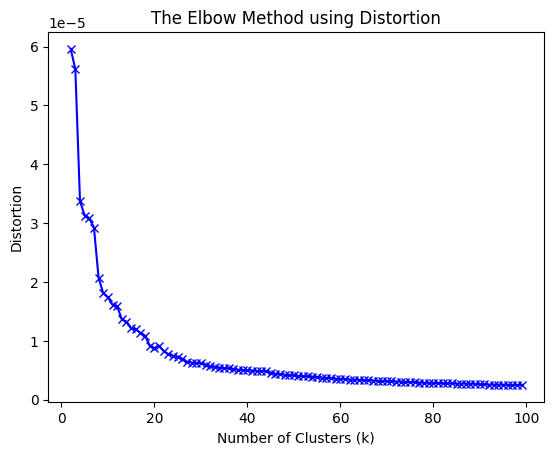

In [43]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range (2,100,1)

for k in K:

    kmeans_model = KMeans(n_clusters=k, random_state=42).fit(similarity_matrices['cosine'])

    distortions.append(sum(np.min(cdist(similarity_matrices['cosine'], kmeans_model.cluster_centers_, 'cosine'), axis=1)**2) / similarity_matrices['cosine'].shape[0])
    
    inertias.append(kmeans_model.inertia_)
    
    mapping1[k] = distortions[-1]
    mapping2[k] = inertias[-1]

print("Distortion values:")
for key, val in mapping1.items():
    print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()


For n_clusters = 45 The average silhouette_score is : 0.21486455453518152
For n_clusters = 46 The average silhouette_score is : 0.21990312056672748
For n_clusters = 47 The average silhouette_score is : 0.2255858854724484
For n_clusters = 48 The average silhouette_score is : 0.22491000662171787
For n_clusters = 49 The average silhouette_score is : 0.23071306532136904
For n_clusters = 50 The average silhouette_score is : 0.23007808007742056
For n_clusters = 51 The average silhouette_score is : 0.23341805786232975
For n_clusters = 52 The average silhouette_score is : 0.23399206180862425
For n_clusters = 53 The average silhouette_score is : 0.23522407825934397
For n_clusters = 54 The average silhouette_score is : 0.2385143205149896


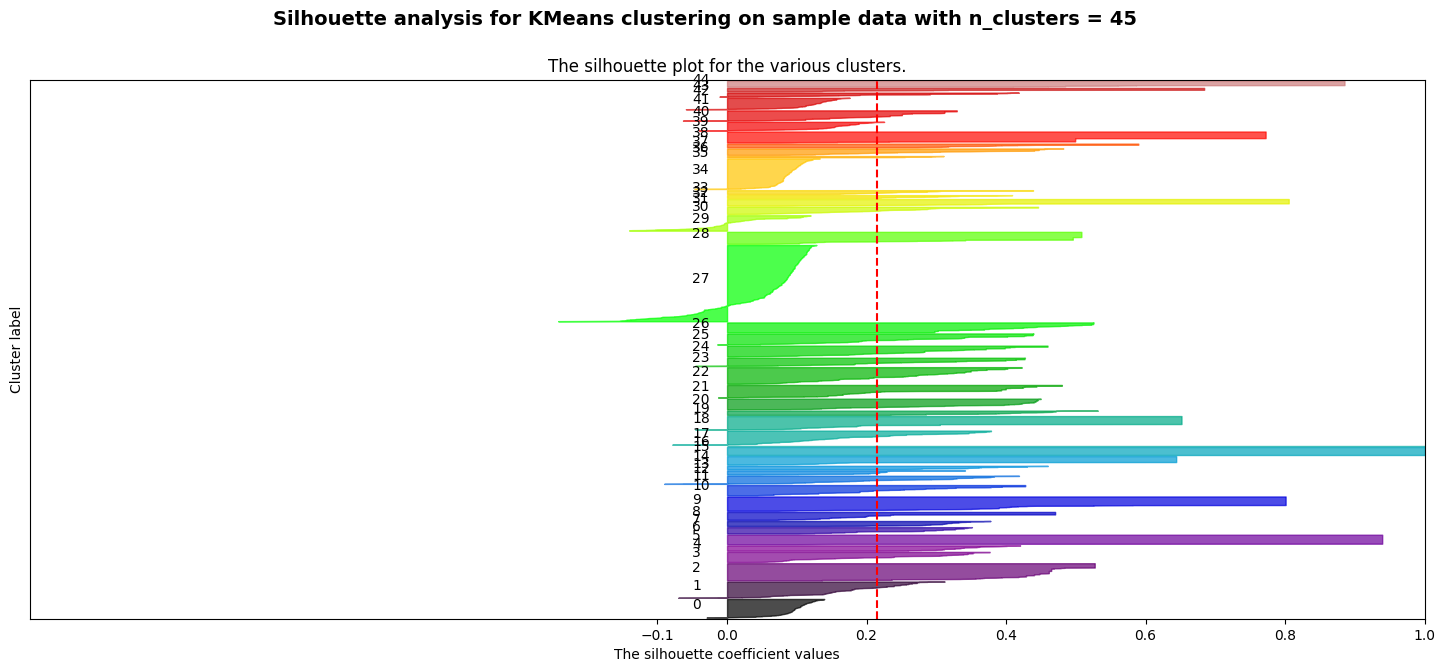

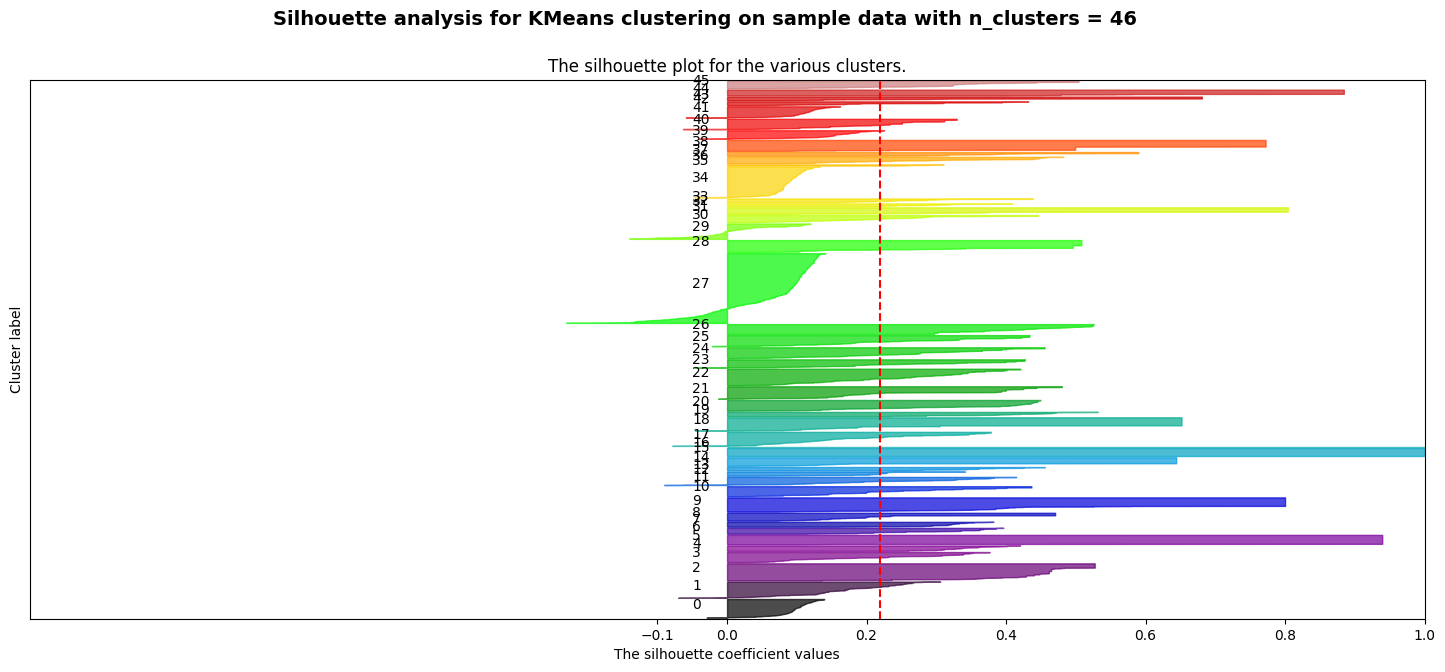

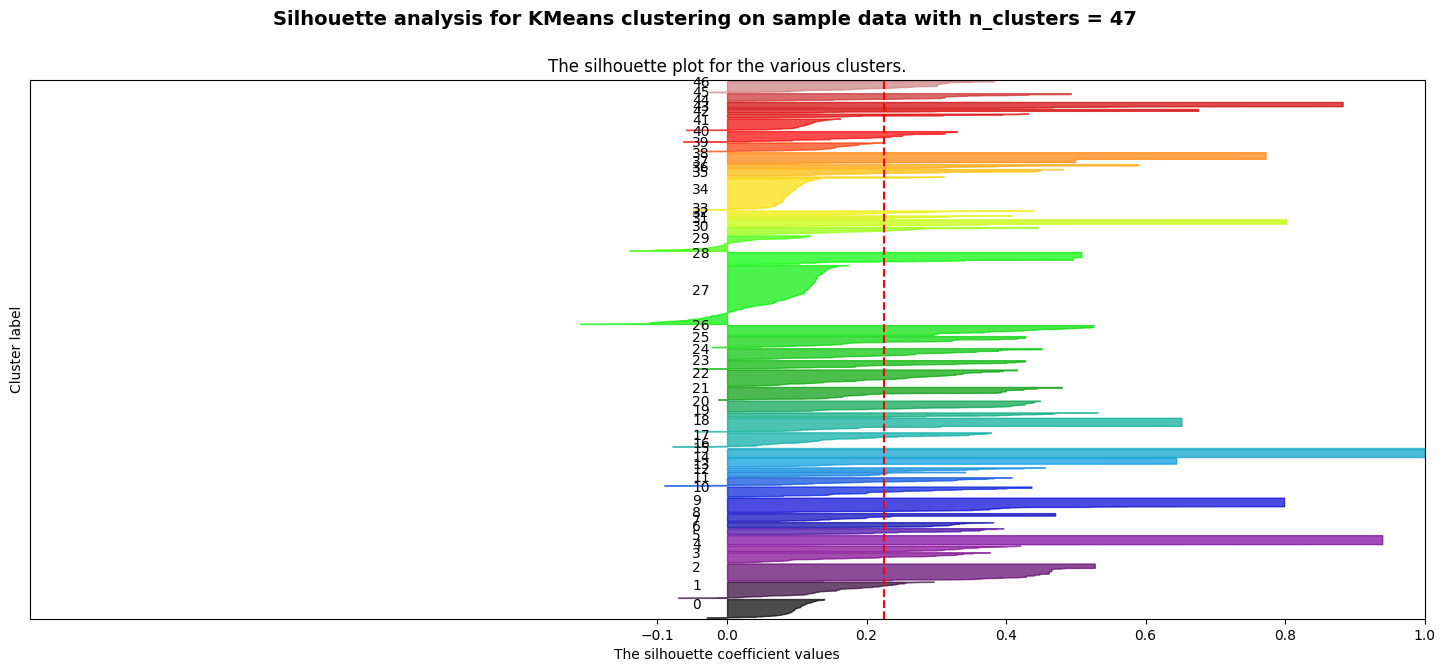

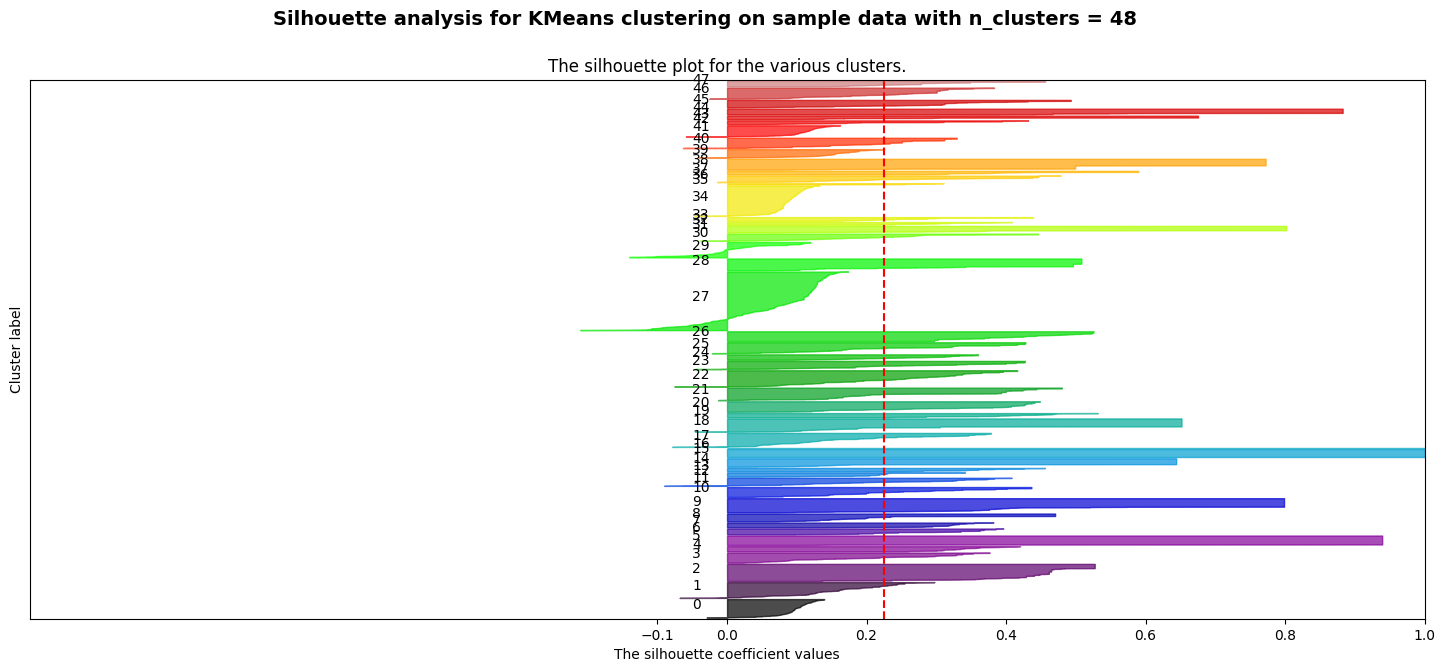

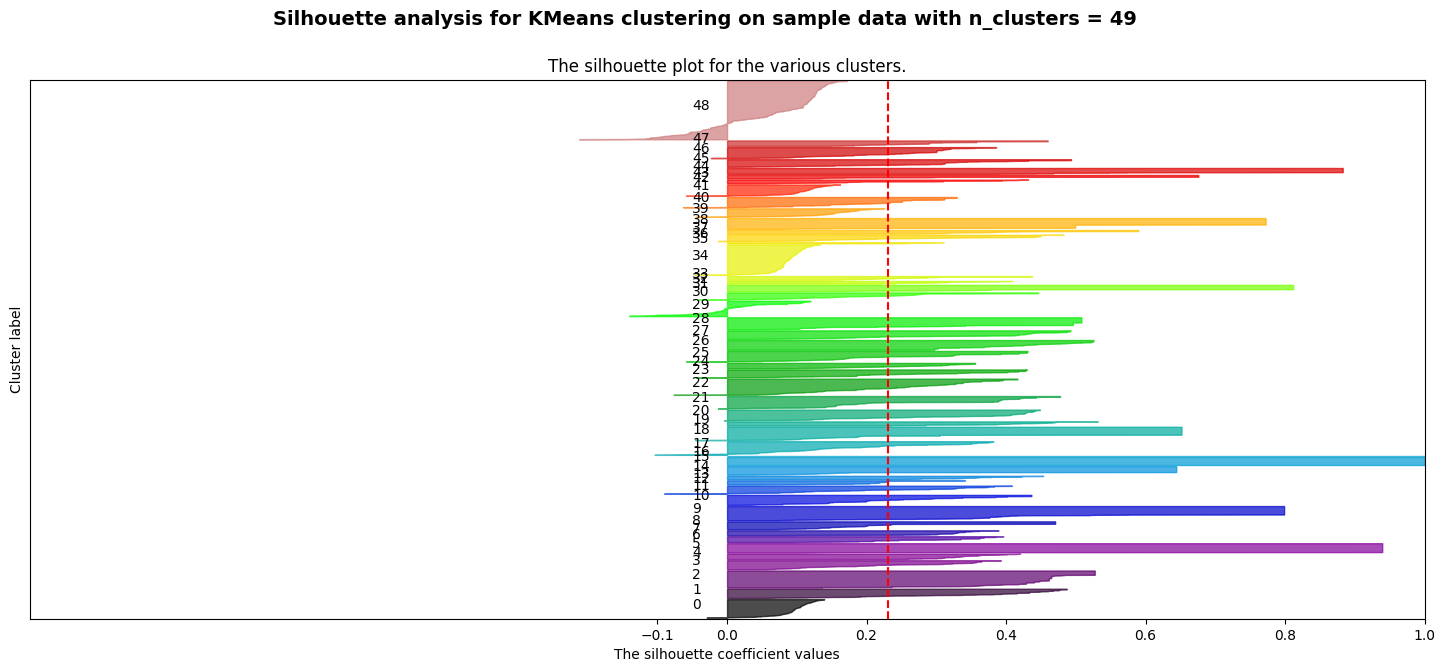

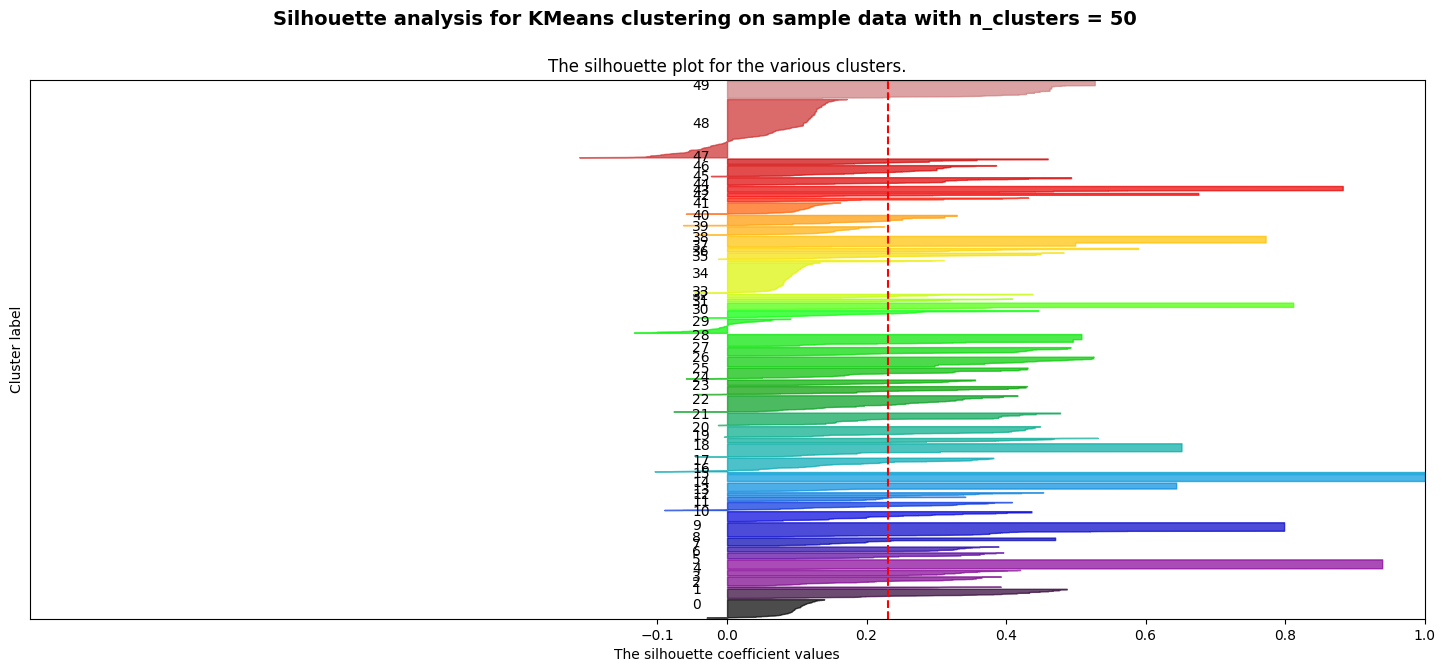

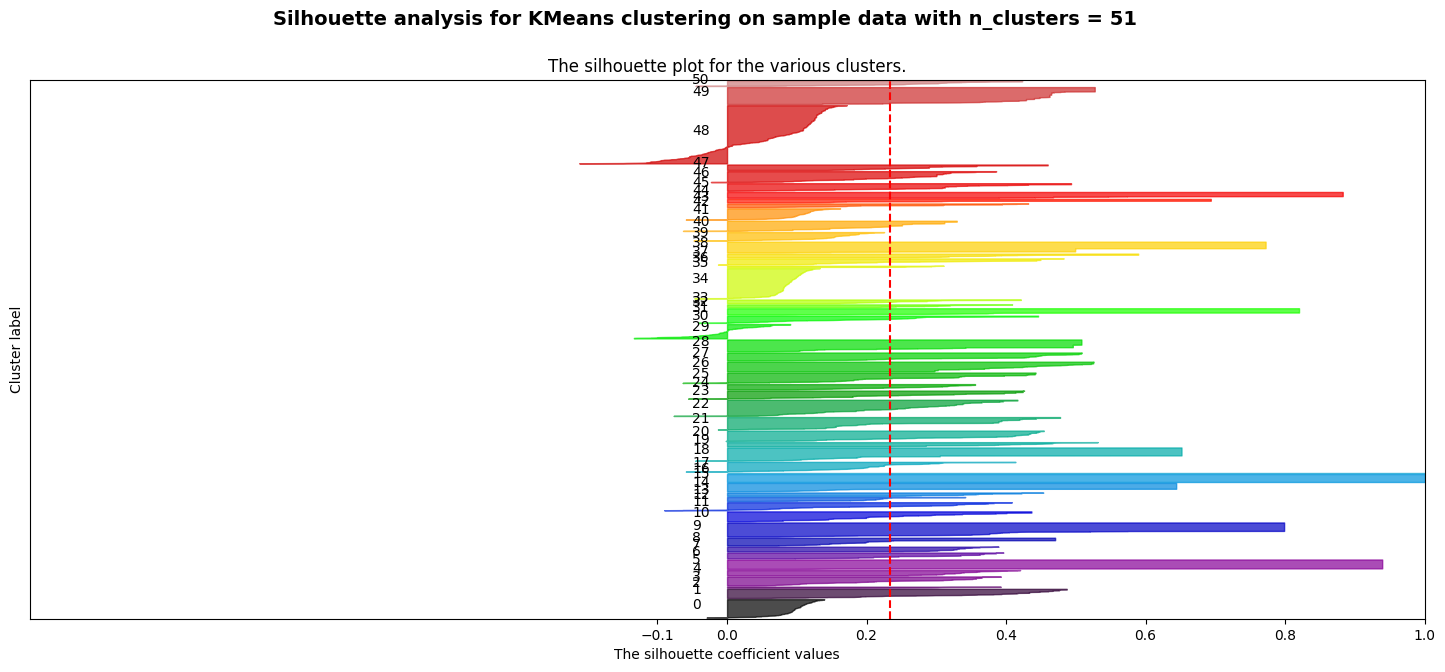

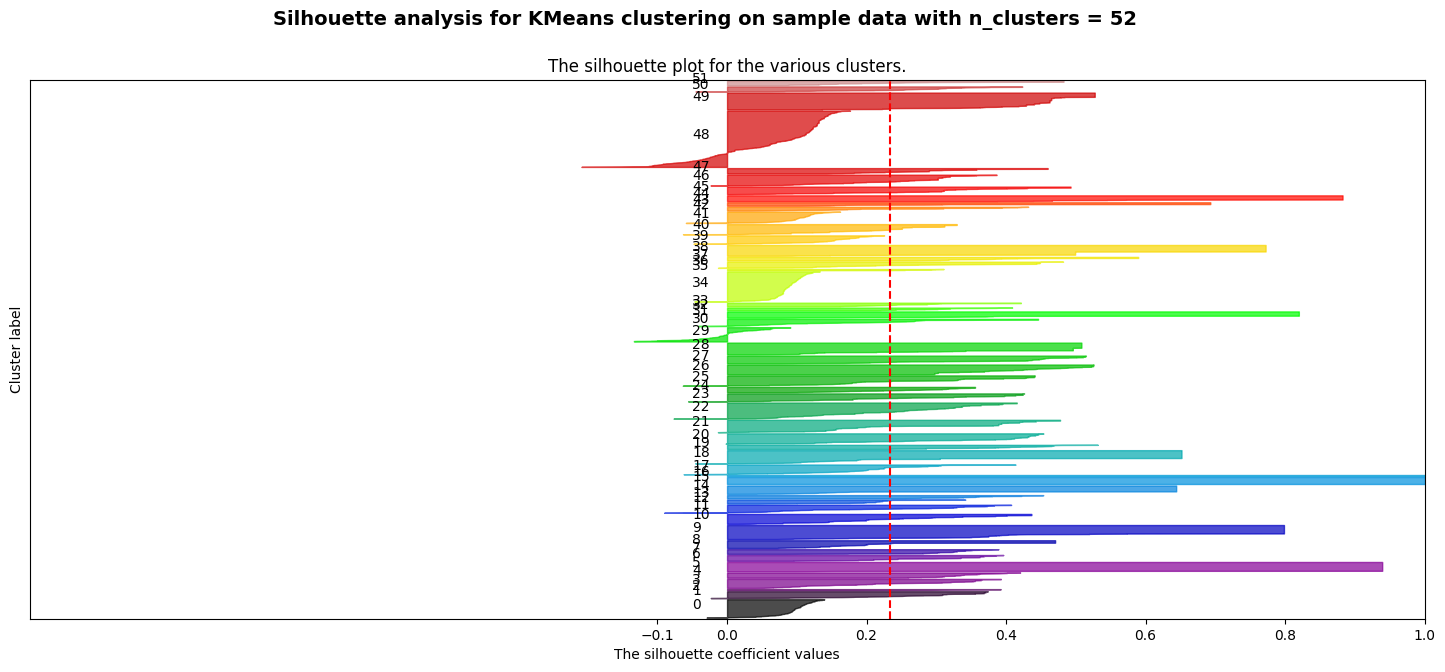

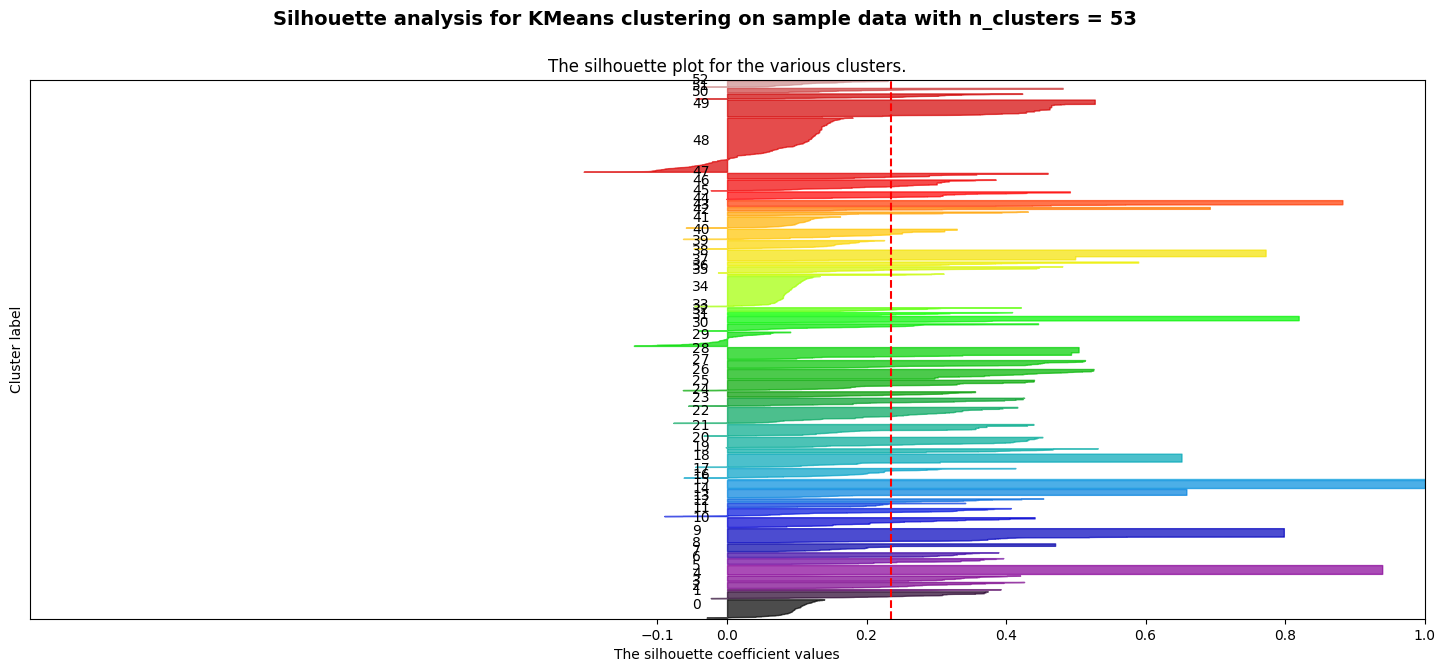

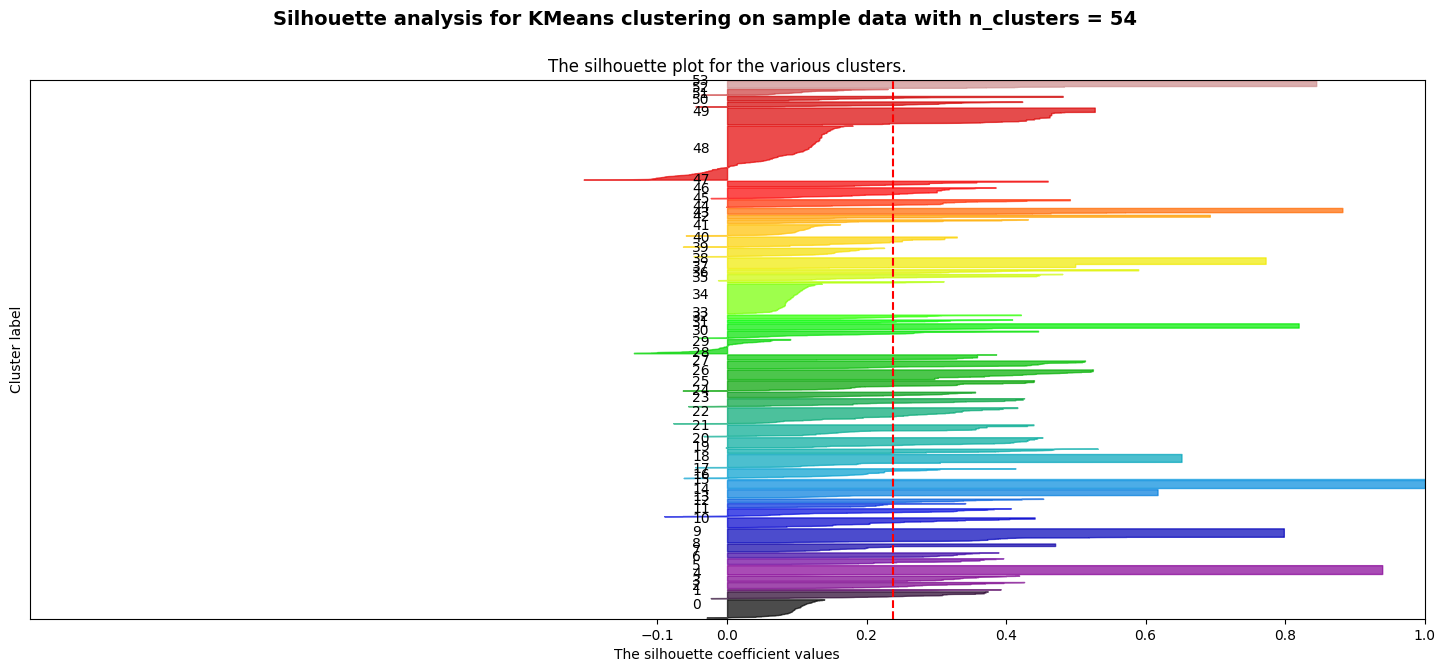

In [44]:
for n_clusters in range(45,55,1):
    fig, ax1 = plt.subplots(1,1)
    fig.set_size_inches(18,7)

    ##Set the silhouette range
    ax1.set_xlim([-1,1])
    ##Set space between plots
    ax1.set_ylim([0, len(similarity_matrices['cosine']) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    
    cluster_labels = clusterer.fit_predict(similarity_matrices['cosine'])

    silhouette_avg = silhouette_score(similarity_matrices['cosine'], cluster_labels, metric='precomputed')
    
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(similarity_matrices['cosine'], cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels==i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor = color,
            edgecolor = color,
            alpha = 0.7
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

With the previous analysis, the ideal n_centers for kmeans is 46 n_centers

In [56]:
optimized_kmeans = KMeans(n_clusters=46, random_state=42)
cluster_labels = optimized_kmeans.fit_predict(similarity_matrices['cosine'])

In [59]:
print(
    "Optimized silhouette",
    silhouette_score(similarity_matrices['cosine'],cluster_labels),
    "Optimized DB",
    davies_bouldin_score(similarity_matrices['cosine'],cluster_labels),
    "Optimized CHS",
    calinski_harabasz_score(similarity_matrices['cosine'],cluster_labels)
)

Optimized silhouette 0.27937092852422485 Optimized DB 1.5504165311123217 Optimized CHS 315.29796431387825


Even with the optimization on the n_clusters, the other scores actually diminished, so maybe, clustering this kind of data is not going to be the best alternative to tr

#### Finding the ideal minPts and eps for the DBSCAN clustering

Based on this article: https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd  
And this thread on stack overflow: https://stackoverflow.com/questions/15050389/estimating-choosing-optimal-hyperparameters-for-dbscan  

Following the rule of thumb indicated on these materials, the usual number of neighbours should be around two times the feature sizes, since we have 4532 rows and 199 columns on the dataset we will use 400 neighbours


In [53]:
neighbors = NearestNeighbors(n_neighbors=20, metric='precomputed')
neighbors_fit = neighbors.fit(similarity_matrices['euclidean'])
distances, indices = neighbors_fit.kneighbors(similarity_matrices['euclidean'])

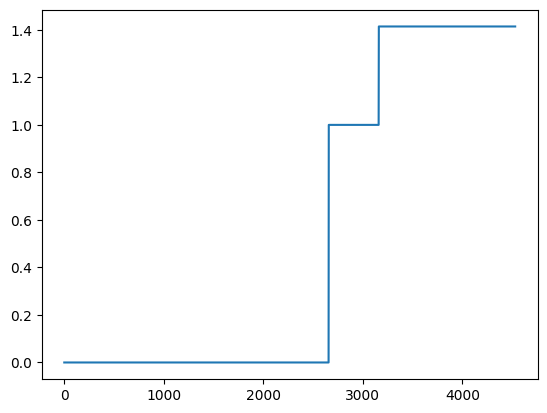

In [54]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

This plot raised several issues, although I don't have a explanation for the score that the DBSCAN with euclidean distance got in the analysis using the default parameters, I know that euclidean distance suffers a lot from the dimensionality curse, so a feature space around 200 might not be so reliable for this clustering algorithm, also, this last plot should have been smooth and not discontinuous like this, given that another clustering algorithm was already selected and fine tuned, I'm going to finish this analysis here to save up time